Mounted at /content/drive
First few rows of the dataset:
   bookID                                              title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   
1       2  Harry Potter and the Order of the Phoenix (Har...   
2       4  Harry Potter and the Chamber of Secrets (Harry...   
3       5  Harry Potter and the Prisoner of Azkaban (Harr...   
4       8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2                J.K. Rowling            4.42  0439554896  9780439554893   
3  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
4  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

  language_code    num_pages  ratings_count  text_reviews_count  \
0           eng          652      

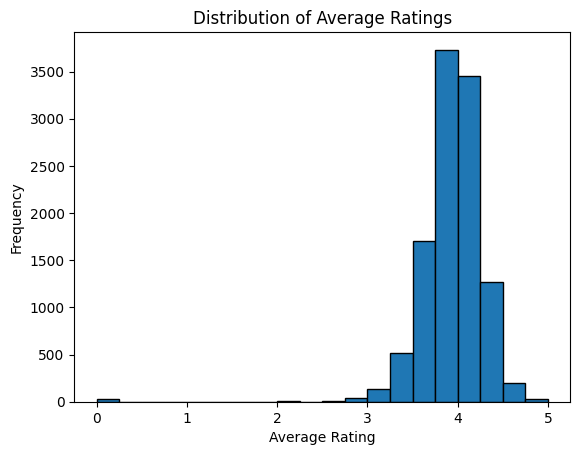

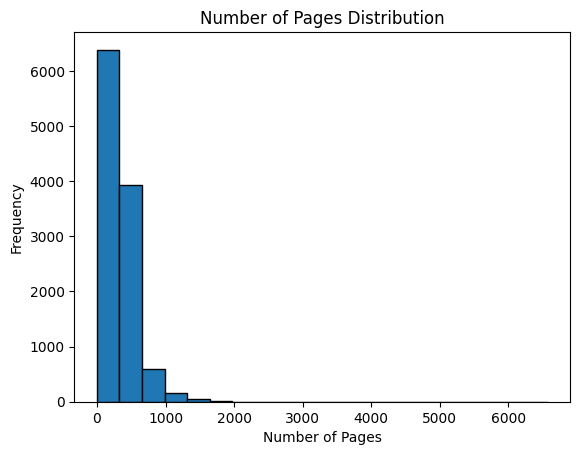

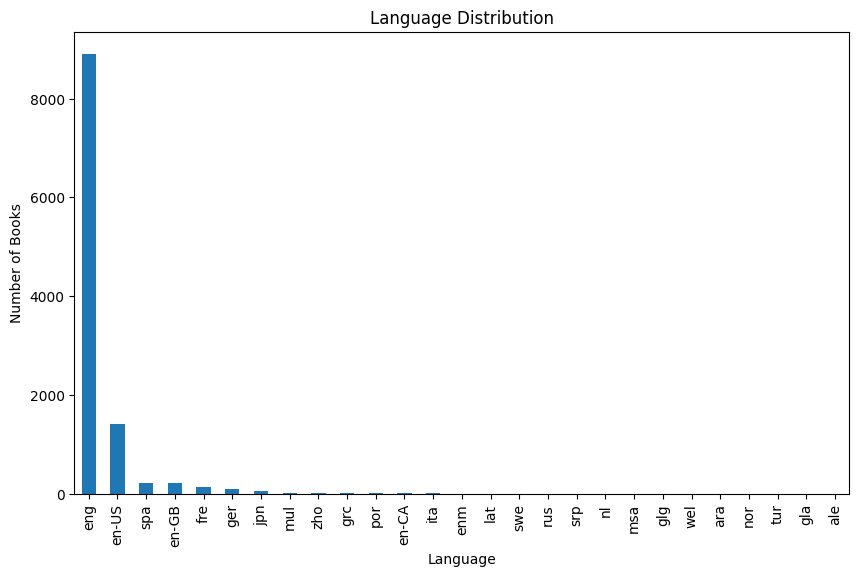

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# DATA SETUP AND EXPLORATORY ANALYSIS

# Mount Google Drive to access the dataset
drive.mount('/content/drive', force_remount=True)

# Adjust this path to where you've stored your dataset in Google Drive
# The dataset: https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks/data
# Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9988858/
dataset_path = '/content/drive/My Drive/books.csv'

try:
    # Load the dataset, handling problematic lines
    df = pd.read_csv(dataset_path, on_bad_lines='skip')

except Exception as e:
    print("An error occurred while loading the dataset:", e)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Get a summary of the dataset
print("\nDataset Info:")
df.info()

# Basic statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Distribution of average ratings
plt.hist(df['average_rating'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Number of pages distribution
plt.hist(df['  num_pages'].dropna(), bins=20, edgecolor='black')
plt.title('Number of Pages Distribution')
plt.xlabel('Number of Pages')
plt.ylabel('Frequency')
plt.show()

# Language distribution
language_counts = df['language_code'].value_counts()
plt.figure(figsize=(10,6))
language_counts.plot(kind='bar')
plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Number of Books')
plt.show()

In [10]:
!pip install fuzzywuzzy

In [11]:
!pip install python-Levenshtein

In [23]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

# FEATURE ENGINEERING, SIMILARITY COMPUTATION, AND RECOMMENDATION FUNCTION

# Convert publication_date to datetime
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')

# Extract year and month as separate features
df['publication_year'] = df['publication_date'].dt.year
df['publication_month'] = df['publication_date'].dt.month

# Vectorizing the 'title' and 'authors' columns
tfidf_title = TfidfVectorizer(stop_words='english')
tfidf_authors = TfidfVectorizer(stop_words='english')

# Fitting and transforming the data
tfidf_matrix_title = tfidf_title.fit_transform(df['title'])
tfidf_matrix_authors = tfidf_authors.fit_transform(df['authors'])

# You might also want to combine these two matrices. Here's one way to do it:
combined_tfidf_matrix = hstack([tfidf_matrix_title, tfidf_matrix_authors])

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Selecting numerical features to normalize
num_features = df[['average_rating', '  num_pages']]  # Add any other numerical features you want to include

# Fitting and transforming the features
num_features_scaled = scaler.fit_transform(num_features)

# If you want to include these features in your combined matrix, convert them to a sparse matrix and hstack them
num_features_sparse = csr_matrix(num_features_scaled)
final_combined_matrix = hstack([combined_tfidf_matrix, num_features_sparse])

# Calculate cosine similarity
cosine_sim = cosine_similarity(final_combined_matrix, final_combined_matrix)

# Since the matrix is in the same order as your DataFrame, we can use the indices of the DataFrame to build a mapping
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Adjust Index Mapping
indices = pd.Series(df.index, index=df['title'])

def recommend_books(input_title, cosine_sim=cosine_sim, df=df, indices=indices):
    # Using fuzzy matching to find the closest title in the dataset
    closest_title = process.extractOne(input_title, df['title'])[0]

    # Get the index of the book that matches the closest title
    idx = indices[closest_title]

    # Flatten the similarity scores to a 1D array
    sim_scores = cosine_sim[idx].flatten()

    # Create a list of book indices and their corresponding similarity scores
    sim_scores = [(i, score) for i, score in enumerate(sim_scores) if i < len(df)]

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices, ensuring they are within the DataFrame's index range
    book_indices = [i[0] for i in sim_scores if i[0] < len(df)]

    # Return the titles of the most similar books
    return df['title'].iloc[book_indices]

# Example usage
# Assuming df is your DataFrame and 'title' is the column with book titles
random_index = random.randint(0, len(df) - 1)
random_book_title = df['title'].iloc[random_index]

# Print the random book title
print(f"Random Book Title: {random_book_title}\n")

# Get recommendations based on the random book title
recommended_books = recommend_books(random_book_title)

# Print the recommended books
print("Books recommended based on your input:\n")
for i, book in enumerate(recommended_books, start=1):
    print(f"{i}. {book}")

Random Book Title: Object-Oriented Programming in C++

Books recommended based on your input:

1. Programming in C
2. Object Thinking
3. programming.java: An Introduction to Programming Using Java: An Introduction to Programming Using Java
4. A Clash of Kings  (A Song of Ice and Fire  #2)
5. Be Here Now
6. Here We All Are
7. Back Bay (Peter Fallon  #1)
8. Tuf Voyaging
9. Bulfinch's Mythology
10. Winston S. Churchill  Volume VIII: 'Never Despair ' 1945-1965


In [36]:
# MODEL PERFORMANCE EVALUATION

# Define ground truth relevance scores (example)
ground_truth_relevance = [4, 4, 4, 0, 0, 0, 0, 0, 0, 0] # Relevance scores for each item

item_1 = "Programming in C"
item_2 = "Object Thinking"
item_3 = "programming.java: An Introduction to Programming Using Java: An Introduction to Programming Using Java"
item_4 = "A Clash of Kings  (A Song of Ice and Fire  #2)"
item_5 = "Be Here Now"
item_6 = "Here We All Are"
item_7 = "Back Bay (Peter Fallon  #1)"
item_8 = "Tuf Voyaging"
item_9 = "Bulfinch's Mythology"
item_10 = "Winston S. Churchill  Volume VIII: 'Never Despair ' 1945-1965"

# Generate a ranked list of recommendations (example)
recommendations = [item_1, item_2, item_3, item_4, item_5, item_6, item_7, item_8, item_9, item_10]

# Calculate DCG
dcg = 0
for i, rel in enumerate(ground_truth_relevance):
    dcg += (rel / np.log2(i + 2))  # Adding 2 because indexing starts from 0

# Sort ground truth relevance scores for IDCG calculation
sorted_ground_truth_relevance = sorted(ground_truth_relevance, reverse=True)

# Calculate IDCG for the same list length as recommendations
idcg = 0
for i, rel in enumerate(sorted_ground_truth_relevance[:len(recommendations)]):
    idcg += (rel / np.log2(i + 2))  # Adding 2 because indexing starts from 0

# Calculate NDCG (Normalized Discounted Cumulative Gain)
ndcg = dcg / idcg

print(f"NDCG: {ndcg:.2f}")

NDCG: 1.00
